In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [5]:
from scipy.optimize import minimize

### Ansatz State

In [6]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [7]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [8]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [9]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [10]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [11]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [12]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [13]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [14]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [15]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [16]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [17]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="L-BFGS-B",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [18]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [19]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [20]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [21]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [22]:
approximated_energies = []

In [23]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [24]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [25]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [26]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [27]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:04,  5.52it/s]
27it [00:03,  8.35it/s]
27it [00:02,  9.02it/s]
27it [00:03,  8.94it/s]
27it [00:03,  8.77it/s]
27it [00:03,  8.57it/s]
27it [00:03,  8.82it/s]
27it [00:03,  8.69it/s]
27it [00:03,  8.82it/s]
27it [00:03,  8.46it/s]
27it [00:03,  8.76it/s]
27it [00:02,  9.20it/s]
27it [00:03,  8.29it/s]
27it [00:02,  9.08it/s]
27it [00:02,  9.41it/s]
27it [00:03,  8.29it/s]
27it [00:03,  8.21it/s]
27it [00:03,  8.32it/s]
27it [00:03,  8.23it/s]
27it [00:03,  7.78it/s]
27it [00:03,  8.07it/s]
27it [00:03,  8.17it/s]
27it [00:03,  8.37it/s]
27it [00:03,  8.21it/s]
27it [00:03,  8.31it/s]
27it [00:03,  8.58it/s]
27it [00:03,  7.94it/s]
27it [00:03,  8.11it/s]
27it [00:03,  7.91it/s]
27it [00:03,  7.14it/s]
27it [00:03,  7.40it/s]
27it [00:04,  6.60it/s]
27it [00:03,  8.16it/s]
27it [00:03,  8.40it/s]
27it [00:03,  8.15it/s]
27it [00:03,  8.05it/s]
27it [00:03,  7.92it/s]
27it [00:03,  8.45it/s]
27it [00:03,  8.43it/s]
27it [00:03,  8.40it/s]
27it [00:03,  7.95it/s]
27it [00:03,  7.

27it [00:03,  7.51it/s]
27it [00:03,  7.56it/s]
27it [00:03,  7.32it/s]
27it [00:03,  7.43it/s]
27it [00:03,  7.64it/s]
27it [00:03,  8.07it/s]
27it [00:03,  7.98it/s]
27it [00:03,  8.34it/s]
27it [00:03,  7.91it/s]
27it [00:03,  7.59it/s]
27it [00:03,  8.05it/s]
27it [00:03,  7.80it/s]
27it [00:03,  7.94it/s]
27it [00:03,  7.95it/s]
27it [00:03,  8.19it/s]
27it [00:03,  8.25it/s]
27it [00:03,  7.67it/s]
27it [00:03,  7.99it/s]
27it [00:03,  7.96it/s]
27it [00:03,  7.97it/s]
27it [00:03,  8.02it/s]
27it [00:03,  7.86it/s]
27it [00:03,  7.50it/s]
27it [00:03,  7.96it/s]
27it [00:03,  7.90it/s]
27it [00:03,  8.17it/s]
27it [00:03,  8.14it/s]
27it [00:03,  7.78it/s]
27it [00:03,  7.68it/s]
27it [00:03,  7.96it/s]
27it [00:03,  7.94it/s]
27it [00:03,  8.73it/s]
27it [00:03,  8.49it/s]
27it [00:03,  8.49it/s]
27it [00:03,  8.43it/s]
27it [00:03,  8.54it/s]
27it [00:03,  8.13it/s]
27it [00:03,  8.49it/s]
27it [00:03,  8.32it/s]
27it [00:03,  8.37it/s]
27it [00:03,  8.38it/s]
27it [00:03,  7.

27it [00:03,  7.97it/s]
27it [00:03,  8.04it/s]
27it [00:03,  8.13it/s]
27it [00:03,  7.94it/s]
27it [00:03,  8.09it/s]
27it [00:03,  8.16it/s]
27it [00:03,  8.08it/s]
27it [00:03,  7.90it/s]
27it [00:03,  8.03it/s]
27it [00:03,  8.06it/s]
27it [00:03,  8.02it/s]
27it [00:03,  8.23it/s]
27it [00:03,  8.08it/s]
27it [00:03,  8.02it/s]
27it [00:03,  8.31it/s]
27it [00:03,  8.17it/s]
27it [00:03,  7.87it/s]
27it [00:03,  7.77it/s]
27it [00:03,  7.89it/s]
27it [00:03,  7.97it/s]
27it [00:03,  8.08it/s]
27it [00:03,  8.08it/s]
27it [00:03,  8.08it/s]
27it [00:03,  7.70it/s]
27it [00:03,  8.02it/s]
27it [00:03,  8.06it/s]
27it [00:03,  8.18it/s]
27it [00:03,  8.55it/s]
27it [00:03,  8.18it/s]
27it [00:03,  8.11it/s]
27it [00:03,  7.88it/s]
27it [00:03,  7.82it/s]
27it [00:03,  7.94it/s]
27it [00:03,  8.03it/s]
27it [00:03,  7.95it/s]
27it [00:03,  7.97it/s]
27it [00:03,  8.01it/s]
27it [00:03,  7.95it/s]
27it [00:03,  7.83it/s]
27it [00:03,  7.89it/s]
27it [00:03,  7.79it/s]
27it [00:03,  8.

[5.14249727 3.1274776  2.67992158 0.58310206 5.48613881 3.59662834
 0.18161122 4.46821429 1.0474327  2.33427702 5.00214478 5.36977256
 2.93026472 5.04785532 0.30162827 4.39321567 6.08842924 3.91337494
 5.94892501 0.27993311 2.87679092 3.44974689 5.70691337 6.2525705
 0.16528291 2.62646504 4.49730337 4.09298196 4.74450738 3.62098547
 2.30927549 3.67778528]


27it [00:03,  8.15it/s]

CPU times: total: 45min 58s
Wall time: 50min 27s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.590790858219277

Approximation Error
0.034591142230530905


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


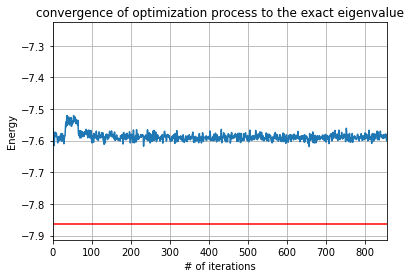

In [28]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [29]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:03,  7.74it/s]
27it [00:03,  7.93it/s]
27it [00:03,  7.88it/s]
27it [00:03,  7.98it/s]
27it [00:03,  8.03it/s]
27it [00:03,  7.96it/s]
27it [00:03,  7.66it/s]
27it [00:03,  7.62it/s]
27it [00:03,  8.05it/s]
27it [00:03,  7.78it/s]
27it [00:03,  7.49it/s]
27it [00:03,  7.66it/s]
27it [00:03,  7.67it/s]
27it [00:03,  7.85it/s]
27it [00:03,  7.85it/s]
27it [00:03,  7.84it/s]
27it [00:03,  7.91it/s]
27it [00:03,  7.99it/s]
27it [00:03,  8.06it/s]
27it [00:03,  7.74it/s]
27it [00:03,  8.08it/s]
27it [00:03,  7.64it/s]
27it [00:03,  8.06it/s]
27it [00:03,  7.88it/s]
27it [00:03,  7.62it/s]
27it [00:03,  7.49it/s]
27it [00:03,  8.20it/s]
27it [00:03,  8.12it/s]
27it [00:03,  7.69it/s]
27it [00:03,  8.14it/s]
27it [00:03,  7.86it/s]
27it [00:03,  7.80it/s]
27it [00:03,  7.71it/s]
27it [00:03,  7.94it/s]
27it [00:03,  7.60it/s]
27it [00:03,  7.37it/s]
27it [00:03,  7.49it/s]
27it [00:03,  7.27it/s]
27it [00:03,  7.72it/s]
27it [00:03,  7.34it/s]
27it [00:03,  7.50it/s]
27it [00:03,  7.

27it [00:03,  7.21it/s]
27it [00:03,  7.51it/s]
27it [00:03,  7.44it/s]
27it [00:03,  7.88it/s]
27it [00:03,  7.56it/s]
27it [00:03,  7.91it/s]
27it [00:03,  7.59it/s]
27it [00:03,  7.61it/s]
27it [00:03,  8.01it/s]
27it [00:03,  7.53it/s]
27it [00:03,  7.90it/s]
27it [00:03,  7.47it/s]
27it [00:03,  7.89it/s]
27it [00:03,  7.48it/s]
27it [00:03,  7.88it/s]
27it [00:03,  7.62it/s]
27it [00:03,  7.54it/s]
27it [00:03,  7.59it/s]
27it [00:03,  7.61it/s]
27it [00:03,  7.48it/s]
27it [00:03,  8.02it/s]
27it [00:03,  7.60it/s]
27it [00:03,  7.88it/s]
27it [00:03,  7.61it/s]
27it [00:03,  7.51it/s]
27it [00:03,  7.90it/s]
27it [00:03,  7.58it/s]
27it [00:03,  7.76it/s]
27it [00:03,  7.27it/s]
27it [00:03,  7.84it/s]
27it [00:03,  7.62it/s]
27it [00:03,  7.73it/s]
27it [00:03,  7.98it/s]
27it [00:03,  7.88it/s]
27it [00:03,  7.88it/s]
27it [00:03,  8.02it/s]
27it [00:03,  7.87it/s]
27it [00:03,  7.29it/s]
27it [00:03,  7.70it/s]
27it [00:03,  7.84it/s]
27it [00:03,  7.87it/s]
27it [00:03,  8.

27it [00:04,  5.43it/s]
27it [00:05,  5.19it/s]
27it [00:04,  5.61it/s]
27it [00:04,  6.15it/s]
27it [00:04,  5.85it/s]
27it [00:04,  5.54it/s]
27it [00:04,  5.95it/s]
27it [00:04,  6.09it/s]
27it [00:03,  7.22it/s]
27it [00:05,  5.19it/s]
27it [00:04,  6.05it/s]
27it [00:04,  5.61it/s]
27it [00:04,  5.42it/s]
27it [00:05,  5.33it/s]
27it [00:04,  5.42it/s]
27it [00:04,  5.58it/s]
27it [00:04,  5.96it/s]
27it [00:04,  5.43it/s]
27it [00:04,  5.60it/s]
27it [00:04,  6.06it/s]
27it [00:04,  6.04it/s]
27it [00:05,  5.29it/s]
27it [00:04,  5.90it/s]
27it [00:04,  5.56it/s]
27it [00:04,  5.57it/s]
27it [00:05,  5.16it/s]
27it [00:04,  5.61it/s]
27it [00:04,  5.59it/s]
27it [00:05,  5.33it/s]
27it [00:05,  5.40it/s]
27it [00:05,  5.11it/s]
27it [00:05,  5.32it/s]
27it [00:04,  5.62it/s]
27it [00:04,  5.74it/s]
27it [00:04,  5.48it/s]
27it [00:04,  6.19it/s]
27it [00:04,  5.81it/s]
27it [00:04,  6.10it/s]
27it [00:04,  5.81it/s]
27it [00:04,  5.82it/s]
27it [00:04,  6.09it/s]
27it [00:04,  5.

[0.7865091  3.12069102 2.72059961 3.85793948 3.51700058 6.25350571
 4.22842565 2.26334812 0.28907046 4.12294574 5.1868368  0.52145901
 1.47827638 3.20391001 0.26143553 5.96616467 2.91515776 1.45420201
 0.15014418 2.43957734 6.06706894 6.0420384  0.19471007 2.56487284
 4.73459307 4.05555439 1.99697539 3.59930153 5.72331138 4.8468198
 0.06165302 0.91672067]


27it [00:02, 10.09it/s]

CPU times: total: 49min 38s
Wall time: 1h 1min 10s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.406362069751179

Approximation Error
0.05804708896129915


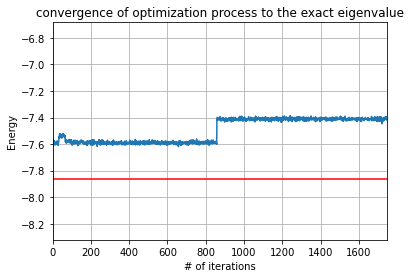

In [30]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [31]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [32]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:01, 11.29it/s]
15it [00:01, 11.65it/s]
15it [00:01, 10.93it/s]
15it [00:01, 10.92it/s]
15it [00:01, 10.18it/s]
15it [00:01, 10.68it/s]
15it [00:01,  9.55it/s]
15it [00:01, 10.80it/s]
15it [00:01, 10.00it/s]
15it [00:01, 10.40it/s]
15it [00:01, 10.18it/s]
15it [00:01, 11.69it/s]
15it [00:01, 12.43it/s]
15it [00:01,  8.94it/s]
15it [00:02,  6.08it/s]
15it [00:02,  5.76it/s]
15it [00:02,  5.85it/s]
15it [00:02,  7.09it/s]
15it [00:02,  7.25it/s]
15it [00:01,  7.84it/s]
15it [00:02,  7.44it/s]
15it [00:02,  7.22it/s]
15it [00:01,  7.72it/s]
15it [00:02,  6.53it/s]
15it [00:02,  7.05it/s]
15it [00:01,  7.60it/s]
15it [00:02,  7.45it/s]
15it [00:01,  7.76it/s]
15it [00:01,  7.85it/s]
15it [00:01,  8.16it/s]
15it [00:01,  8.46it/s]
15it [00:01,  8.63it/s]
15it [00:01,  7.66it/s]
15it [00:02,  7.42it/s]
15it [00:01,  8.79it/s]
15it [00:01,  8.72it/s]
15it [00:01,  9.78it/s]
15it [00:01,  8.78it/s]
15it [00:02,  7.25it/s]
15it [00:01,  7.87it/s]
15it [00:01,  8.18it/s]
15it [00:01,  8.

15it [00:01,  9.56it/s]
15it [00:01,  8.90it/s]
15it [00:01,  9.31it/s]
15it [00:01,  8.19it/s]
15it [00:01,  8.15it/s]
15it [00:01,  8.37it/s]
15it [00:01,  7.55it/s]
15it [00:01,  9.10it/s]
15it [00:01,  8.67it/s]
15it [00:01,  8.57it/s]
15it [00:01,  9.00it/s]
15it [00:01,  9.04it/s]
15it [00:01,  8.28it/s]
15it [00:01,  8.89it/s]
15it [00:01,  7.89it/s]
15it [00:01,  9.67it/s]
15it [00:01,  8.69it/s]
15it [00:01,  8.91it/s]
15it [00:01,  8.05it/s]
15it [00:01,  8.78it/s]
15it [00:01,  7.91it/s]
15it [00:01,  8.23it/s]
15it [00:01,  8.61it/s]
15it [00:01,  8.92it/s]
15it [00:01, 11.25it/s]
15it [00:01,  9.25it/s]
15it [00:01,  8.09it/s]
15it [00:01,  8.84it/s]
15it [00:02,  7.48it/s]
15it [00:01,  9.53it/s]
15it [00:01,  9.04it/s]
15it [00:01,  9.29it/s]
15it [00:01,  9.63it/s]
15it [00:01,  9.17it/s]
15it [00:01,  8.63it/s]
15it [00:01,  8.21it/s]
15it [00:01,  8.30it/s]
15it [00:01,  8.63it/s]
15it [00:01,  7.78it/s]
15it [00:02,  7.47it/s]
15it [00:01,  9.19it/s]
15it [00:01,  8.

15it [00:01, 10.13it/s]
15it [00:01,  9.63it/s]
15it [00:01,  9.85it/s]
15it [00:01,  9.46it/s]
15it [00:01,  9.82it/s]
15it [00:01, 10.13it/s]
15it [00:01,  9.02it/s]
15it [00:01,  9.03it/s]
15it [00:01, 10.37it/s]
15it [00:01,  9.15it/s]
15it [00:01,  9.36it/s]
15it [00:01,  9.73it/s]
15it [00:01,  9.15it/s]
15it [00:01, 10.20it/s]
15it [00:01,  8.92it/s]
15it [00:01,  9.97it/s]
15it [00:01,  9.05it/s]
15it [00:01,  9.73it/s]
15it [00:01, 10.31it/s]
15it [00:01,  9.59it/s]
15it [00:01,  9.00it/s]
15it [00:01,  9.54it/s]
15it [00:01, 10.48it/s]
15it [00:01, 10.08it/s]
15it [00:01, 10.00it/s]
15it [00:01,  9.46it/s]
15it [00:01,  8.57it/s]
15it [00:01,  9.22it/s]
15it [00:01,  9.97it/s]
15it [00:01,  9.66it/s]
15it [00:01,  8.26it/s]
15it [00:01,  8.32it/s]
15it [00:01,  8.18it/s]
15it [00:01,  8.61it/s]
15it [00:01,  8.40it/s]
15it [00:01,  8.39it/s]
15it [00:01,  8.85it/s]
15it [00:02,  7.32it/s]
15it [00:01,  8.50it/s]
15it [00:01,  8.43it/s]
15it [00:01,  9.23it/s]
15it [00:01,  8.

[1.97896897 4.5856562  3.24761021 1.70258315 5.08800737 2.61224284
 5.67920861 6.21782327 5.53201778 6.21395899 2.21031118 1.3253068
 4.63751375 1.21322301 5.03027858 3.33203321 4.09078062 1.20421673
 0.98371345 4.28950616 4.47051429 1.83285608 2.28773762 2.69558565
 1.39350232 5.13541376 3.924237   3.92793977 3.08644739 4.04854119
 0.33447907 2.74794087]


15it [00:01,  8.84it/s]

CPU times: total: 20min 29s
Wall time: 20min 59s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.7598268359992371

Approximation Error
0.5908915892136654


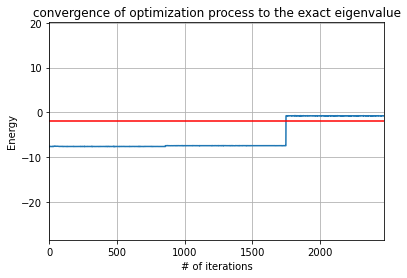

In [33]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [34]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:01,  7.62it/s]
15it [00:01,  8.48it/s]
15it [00:02,  7.33it/s]
15it [00:01,  9.40it/s]
15it [00:01,  7.83it/s]
15it [00:01,  7.68it/s]
15it [00:01,  7.71it/s]
15it [00:01,  8.07it/s]
15it [00:01,  8.88it/s]
15it [00:01,  8.50it/s]
15it [00:01,  8.45it/s]
15it [00:01,  8.68it/s]
15it [00:01,  7.57it/s]
15it [00:01,  8.45it/s]
15it [00:01,  8.84it/s]
15it [00:01,  8.20it/s]
15it [00:01,  7.87it/s]
15it [00:01,  9.48it/s]
15it [00:01,  7.98it/s]
15it [00:01,  7.68it/s]
15it [00:01,  8.67it/s]
15it [00:01,  8.14it/s]
15it [00:01,  8.14it/s]
15it [00:01,  7.56it/s]
15it [00:01,  7.71it/s]
15it [00:01,  8.52it/s]
15it [00:01,  7.90it/s]
15it [00:01,  8.27it/s]
15it [00:01,  8.71it/s]
15it [00:01,  8.87it/s]
15it [00:01,  8.21it/s]
15it [00:01,  7.82it/s]
15it [00:01,  8.36it/s]
15it [00:01,  7.76it/s]
15it [00:01,  8.77it/s]
15it [00:01,  8.20it/s]
15it [00:01,  8.35it/s]
15it [00:01,  8.33it/s]
15it [00:01,  8.26it/s]
15it [00:01,  8.78it/s]
15it [00:01,  8.01it/s]
15it [00:01,  7.

15it [00:01,  8.18it/s]
15it [00:01,  9.29it/s]
15it [00:01, 10.06it/s]
15it [00:01,  8.46it/s]
15it [00:01,  7.72it/s]
15it [00:01,  8.82it/s]
15it [00:01,  9.07it/s]
15it [00:01,  8.98it/s]
15it [00:01,  8.61it/s]
15it [00:01,  8.90it/s]
15it [00:01,  9.12it/s]
15it [00:01,  8.90it/s]
15it [00:01,  9.20it/s]
15it [00:01,  9.53it/s]
15it [00:01,  9.44it/s]
15it [00:01,  8.47it/s]
15it [00:01,  8.27it/s]
15it [00:01,  8.22it/s]
15it [00:01,  8.31it/s]
15it [00:01,  8.37it/s]
15it [00:01,  9.22it/s]
15it [00:01,  8.78it/s]
15it [00:01,  8.07it/s]
15it [00:01,  8.46it/s]
15it [00:01,  7.58it/s]
15it [00:01,  8.00it/s]
15it [00:01,  8.82it/s]
15it [00:01,  8.48it/s]
15it [00:01,  8.06it/s]
15it [00:01,  9.15it/s]
15it [00:01,  8.26it/s]
15it [00:01,  8.73it/s]
15it [00:01,  8.65it/s]
15it [00:01,  8.78it/s]
15it [00:01,  8.50it/s]
15it [00:01,  9.23it/s]
15it [00:01,  9.33it/s]
15it [00:01,  8.72it/s]
15it [00:01,  8.72it/s]
15it [00:01,  8.63it/s]
15it [00:01,  8.19it/s]
15it [00:01,  8.

15it [00:01, 10.99it/s]
15it [00:01, 12.27it/s]
15it [00:01, 11.95it/s]
15it [00:01, 11.30it/s]
15it [00:01, 10.40it/s]
15it [00:01, 10.25it/s]
15it [00:01,  9.65it/s]
15it [00:01,  8.86it/s]
15it [00:01,  8.95it/s]
15it [00:01,  9.56it/s]
15it [00:01,  8.67it/s]
15it [00:01,  9.46it/s]
15it [00:01,  8.32it/s]
15it [00:01,  9.03it/s]
15it [00:01, 10.12it/s]
15it [00:01,  8.84it/s]
15it [00:01, 10.61it/s]
15it [00:01, 12.93it/s]
15it [00:01, 13.92it/s]
15it [00:00, 15.06it/s]
15it [00:01, 12.56it/s]
15it [00:01,  8.73it/s]
15it [00:01,  7.84it/s]
15it [00:01,  8.17it/s]
15it [00:01,  8.03it/s]
15it [00:02,  7.12it/s]
15it [00:01,  8.12it/s]
15it [00:01,  8.66it/s]
15it [00:02,  7.15it/s]
15it [00:01,  7.96it/s]
15it [00:02,  7.32it/s]
15it [00:01,  7.94it/s]
15it [00:02,  7.22it/s]
15it [00:01,  7.78it/s]
15it [00:02,  7.33it/s]
15it [00:02,  7.41it/s]
15it [00:01,  7.82it/s]
15it [00:01,  7.75it/s]
15it [00:01,  7.85it/s]
15it [00:02,  7.23it/s]
15it [00:01,  8.03it/s]
15it [00:01,  8.

[5.37758169 6.08634821 2.91339738 4.05405407 3.30961621 5.07128538
 0.09887055 4.80771112 1.08086018 0.57137893 4.57741265 1.23729165
 5.72010536 2.50486977 5.38168539 2.82341034 3.73845917 3.35914077
 4.50073266 2.27838284 3.54137764 0.79470667 5.76246206 5.95447632
 1.35320938 0.98076275 5.95838055 0.44177505 5.27456482 4.98611479
 5.41638096 5.63686358]


15it [00:01,  9.03it/s]

CPU times: total: 23min 30s
Wall time: 1h 48min 24s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.7399879188330215

Approximation Error
0.6015733228522497


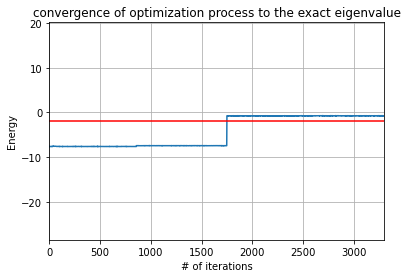

In [35]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [36]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [37]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:01,  7.57it/s]
11it [00:01,  8.28it/s]
11it [00:01,  8.87it/s]
11it [00:01,  8.10it/s]
11it [00:01,  6.64it/s]
11it [00:01,  6.82it/s]
11it [00:01,  6.37it/s]
11it [00:01,  7.58it/s]
11it [00:01,  7.24it/s]
11it [00:01,  7.17it/s]
11it [00:01,  7.59it/s]
11it [00:01,  7.31it/s]
11it [00:01,  7.78it/s]
11it [00:01,  7.07it/s]
11it [00:01,  5.95it/s]
11it [00:01,  7.75it/s]
11it [00:01,  7.45it/s]
11it [00:01,  7.29it/s]
11it [00:01,  7.29it/s]
11it [00:01,  6.53it/s]
11it [00:01,  7.14it/s]
11it [00:01,  6.55it/s]
11it [00:01,  6.63it/s]
11it [00:01,  7.28it/s]
11it [00:01,  7.02it/s]
11it [00:01,  6.71it/s]
11it [00:01,  6.52it/s]
11it [00:01,  6.32it/s]
11it [00:01,  8.49it/s]
11it [00:01,  7.54it/s]
11it [00:01,  7.38it/s]
11it [00:01,  7.57it/s]
11it [00:01,  7.31it/s]
11it [00:01,  6.43it/s]
11it [00:01,  6.47it/s]
11it [00:01,  6.85it/s]
11it [00:01,  7.60it/s]
11it [00:01,  7.01it/s]
11it [00:01,  7.13it/s]
11it [00:01,  7.83it/s]
11it [00:01,  8.48it/s]
11it [00:01,  7.

11it [00:01,  8.49it/s]
11it [00:01,  9.89it/s]
11it [00:01, 10.18it/s]
11it [00:01,  9.33it/s]
11it [00:01,  9.99it/s]
11it [00:01, 10.61it/s]
11it [00:01,  9.13it/s]
11it [00:01,  7.70it/s]
11it [00:01,  8.93it/s]
11it [00:01,  8.88it/s]
11it [00:01,  7.61it/s]
11it [00:01,  7.44it/s]
11it [00:01,  8.34it/s]
11it [00:01,  9.16it/s]
11it [00:01,  9.35it/s]
11it [00:01,  9.55it/s]
11it [00:01, 10.27it/s]
11it [00:01,  9.50it/s]
11it [00:01,  9.46it/s]
11it [00:01,  8.42it/s]
11it [00:01, 10.86it/s]
11it [00:01,  9.29it/s]
11it [00:01,  7.77it/s]
11it [00:01,  8.62it/s]
11it [00:01,  9.22it/s]
11it [00:01,  9.04it/s]
11it [00:01,  7.60it/s]
11it [00:01,  8.60it/s]
11it [00:01,  7.08it/s]
11it [00:01,  8.22it/s]
11it [00:01,  9.67it/s]
11it [00:01,  7.64it/s]
11it [00:01,  8.72it/s]
11it [00:01,  8.19it/s]
11it [00:01,  8.05it/s]
11it [00:01,  8.00it/s]
11it [00:01,  6.57it/s]
11it [00:01,  7.53it/s]
11it [00:01,  9.45it/s]
11it [00:01,  9.90it/s]
11it [00:01, 10.87it/s]
11it [00:01,  8.

11it [00:01,  9.98it/s]
11it [00:01,  9.56it/s]
11it [00:01,  9.70it/s]
11it [00:01,  9.45it/s]
11it [00:01,  9.19it/s]
11it [00:01, 10.16it/s]
11it [00:01,  9.21it/s]
11it [00:01,  8.76it/s]
11it [00:01,  8.47it/s]
11it [00:01,  8.29it/s]
11it [00:01,  8.12it/s]
11it [00:01,  8.45it/s]
11it [00:01, 10.20it/s]
11it [00:01,  8.93it/s]
11it [00:01,  8.98it/s]
11it [00:01,  8.73it/s]
11it [00:01,  9.77it/s]
11it [00:01,  8.69it/s]
11it [00:01,  9.94it/s]
11it [00:01,  9.56it/s]
11it [00:01,  8.41it/s]
11it [00:01,  9.03it/s]
11it [00:01,  9.34it/s]
11it [00:01,  9.58it/s]
11it [00:01,  8.90it/s]
11it [00:01,  9.00it/s]
11it [00:01,  9.11it/s]
11it [00:01,  9.06it/s]
11it [00:01,  8.86it/s]
11it [00:01,  8.49it/s]
11it [00:01,  8.06it/s]
11it [00:01,  8.78it/s]
11it [00:01,  9.34it/s]
11it [00:01,  8.64it/s]
11it [00:01,  8.26it/s]
11it [00:01,  7.88it/s]
11it [00:01,  9.04it/s]
11it [00:01,  8.05it/s]
11it [00:01,  9.12it/s]
11it [00:01,  8.20it/s]
11it [00:01,  7.18it/s]
11it [00:01,  8.

[5.76157303 2.48876574 6.10754427 3.24867928 2.26509785 5.53788196
 1.70858395 0.9028719  0.13738672 4.83036595 3.65116439 5.9687294
 5.52709762 5.52661902 1.52863778 5.02567644 3.56503476 2.80370772
 2.97980348 3.83211004 5.42954708 1.57651726 1.1873481  3.91199247
 1.40037366 3.21041636 0.66405329 3.52922262 4.82718924 0.23030391
 5.96204898 1.73453843]


11it [00:01,  7.32it/s]

CPU times: total: 19min 8s
Wall time: 20min 48s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.3891170919235016

Approximation Error
0.8053913987631719


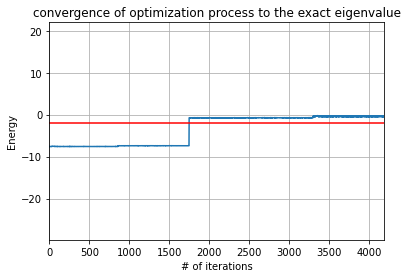

In [38]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [39]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:01,  6.92it/s]
11it [00:01,  6.97it/s]
11it [00:01,  6.56it/s]
11it [00:01,  6.66it/s]
11it [00:01,  7.56it/s]
11it [00:01,  7.13it/s]
11it [00:01,  7.66it/s]
11it [00:01,  7.12it/s]
11it [00:01,  7.05it/s]
11it [00:01,  6.56it/s]
11it [00:01,  6.90it/s]
11it [00:01,  7.42it/s]
11it [00:01,  7.08it/s]
11it [00:01,  6.82it/s]
11it [00:01,  7.28it/s]
11it [00:01,  7.40it/s]
11it [00:01,  8.52it/s]
11it [00:01,  7.84it/s]
11it [00:01,  6.35it/s]
11it [00:01,  5.75it/s]
11it [00:01,  6.85it/s]
11it [00:01,  5.74it/s]
11it [00:01,  6.12it/s]
11it [00:01,  6.04it/s]
11it [00:01,  6.15it/s]
11it [00:01,  6.38it/s]
11it [00:01,  5.71it/s]
11it [00:01,  5.62it/s]
11it [00:01,  5.95it/s]
11it [00:02,  5.42it/s]
11it [00:01,  5.74it/s]
11it [00:01,  6.23it/s]
11it [00:01,  6.32it/s]
11it [00:01,  6.59it/s]
11it [00:01,  6.80it/s]
11it [00:01,  6.69it/s]
11it [00:01,  6.34it/s]
11it [00:01,  6.00it/s]
11it [00:01,  6.68it/s]
11it [00:01,  6.70it/s]
11it [00:01,  6.58it/s]
11it [00:01,  6.

11it [00:02,  5.33it/s]
11it [00:02,  5.02it/s]
11it [00:01,  6.02it/s]
11it [00:01,  5.62it/s]
11it [00:01,  5.58it/s]
11it [00:01,  6.88it/s]
11it [00:02,  5.06it/s]
11it [00:01,  5.59it/s]
11it [00:01,  5.70it/s]
11it [00:01,  6.05it/s]
11it [00:01,  6.05it/s]
11it [00:01,  6.14it/s]
11it [00:02,  5.27it/s]
11it [00:01,  6.08it/s]
11it [00:01,  6.31it/s]
11it [00:01,  5.91it/s]
11it [00:01,  6.17it/s]
11it [00:01,  6.21it/s]
11it [00:01,  5.63it/s]
11it [00:01,  6.81it/s]
11it [00:01,  6.36it/s]
11it [00:01,  6.20it/s]
11it [00:01,  6.99it/s]
11it [00:01,  7.18it/s]
11it [00:01,  6.19it/s]
11it [00:01,  6.57it/s]
11it [00:01,  6.33it/s]
11it [00:01,  5.84it/s]
11it [00:01,  6.33it/s]
11it [00:01,  5.92it/s]
11it [00:01,  6.24it/s]
11it [00:01,  6.23it/s]
11it [00:01,  7.04it/s]
11it [00:01,  7.32it/s]
11it [00:01,  6.96it/s]
11it [00:01,  6.51it/s]
11it [00:01,  7.56it/s]
11it [00:01,  7.44it/s]
11it [00:01,  6.74it/s]
11it [00:01,  6.99it/s]
11it [00:01,  6.32it/s]
11it [00:01,  6.

11it [00:01, 10.17it/s]
11it [00:01,  9.54it/s]
11it [00:01,  9.94it/s]
11it [00:01, 10.72it/s]
11it [00:01, 10.06it/s]
11it [00:01,  9.25it/s]
11it [00:01, 10.70it/s]
11it [00:01,  9.18it/s]
11it [00:01,  9.34it/s]
11it [00:01,  9.69it/s]
11it [00:01,  9.71it/s]
11it [00:01, 10.75it/s]
11it [00:01, 10.22it/s]
11it [00:01, 10.22it/s]
11it [00:01, 10.73it/s]
11it [00:00, 13.37it/s]
11it [00:00, 13.03it/s]
11it [00:00, 12.88it/s]
11it [00:00, 13.55it/s]
11it [00:00, 12.37it/s]
11it [00:00, 14.54it/s]
11it [00:00, 13.15it/s]
11it [00:00, 11.98it/s]
11it [00:00, 12.76it/s]
11it [00:00, 11.45it/s]
11it [00:00, 11.31it/s]
11it [00:01, 10.18it/s]
11it [00:01, 10.37it/s]
11it [00:01,  9.93it/s]
11it [00:01, 10.25it/s]
11it [00:01,  9.94it/s]
11it [00:01,  9.35it/s]
11it [00:01, 10.25it/s]
11it [00:01,  5.98it/s]
11it [00:01,  5.70it/s]
11it [00:02,  4.90it/s]
11it [00:01,  5.54it/s]
11it [00:01,  6.56it/s]
11it [00:01,  7.94it/s]
11it [00:01,  8.43it/s]
11it [00:01,  7.29it/s]
11it [00:01,  6.

11it [00:01,  7.61it/s]
11it [00:01,  6.74it/s]
11it [00:01,  6.79it/s]
11it [00:01,  5.89it/s]
11it [00:01,  6.23it/s]
11it [00:01,  6.36it/s]
11it [00:01,  7.09it/s]
11it [00:01,  6.74it/s]
11it [00:01,  6.36it/s]
11it [00:01,  7.56it/s]
11it [00:01,  7.34it/s]
11it [00:01,  7.75it/s]
11it [00:01,  8.08it/s]
11it [00:01,  7.44it/s]
11it [00:01,  7.27it/s]
11it [00:02,  5.27it/s]
11it [00:02,  5.04it/s]
11it [00:02,  5.42it/s]
11it [00:01,  7.27it/s]
11it [00:01,  7.74it/s]
11it [00:01,  6.67it/s]
11it [00:01,  7.43it/s]
11it [00:01,  7.59it/s]
11it [00:01,  8.15it/s]
11it [00:01,  7.78it/s]
11it [00:01,  7.14it/s]
11it [00:01,  6.73it/s]
11it [00:01,  8.92it/s]
11it [00:01,  7.86it/s]
11it [00:01,  5.90it/s]
11it [00:01,  7.17it/s]
11it [00:01,  6.55it/s]
11it [00:01,  6.93it/s]


[2.15800806 1.85855378 5.73279043 0.80365416 3.13554717 5.01990785
 4.71475594 3.42979015 1.46978428 3.95169773 0.41876482 0.5575681
 2.01508787 0.3965206  0.20466555 5.92378646 5.73479723 2.2240761
 4.35331925 5.28536988 5.39456885 0.57084863 5.80853038 5.38051205
 2.92254248 4.53445148 4.26881487 4.99155829 1.82797509 2.08403212
 2.35339231 4.99556083]


11it [00:01,  7.12it/s]

CPU times: total: 25min 35s
Wall time: 27min 58s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.20189942969037372

Approximation Error
0.899024313200096


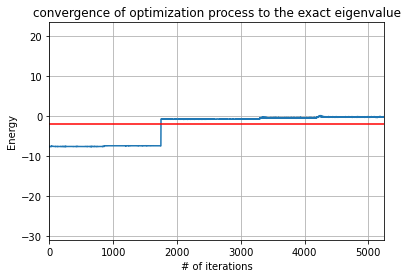

In [40]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [41]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [42]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [43]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00,  9.15it/s]
7it [00:00,  8.80it/s]
7it [00:00,  8.85it/s]
7it [00:00,  9.23it/s]
7it [00:00,  9.32it/s]
7it [00:00,  8.99it/s]
7it [00:00,  8.85it/s]
7it [00:00,  9.62it/s]
7it [00:00,  9.08it/s]
7it [00:00, 10.26it/s]
7it [00:00,  9.64it/s]
7it [00:00,  8.01it/s]
7it [00:00, 10.47it/s]
7it [00:00,  8.30it/s]
7it [00:00,  8.63it/s]
7it [00:00,  9.05it/s]
7it [00:00,  9.91it/s]
7it [00:00,  9.97it/s]
7it [00:00,  9.94it/s]
7it [00:00,  8.54it/s]
7it [00:00,  8.27it/s]
7it [00:00,  8.99it/s]
7it [00:00,  9.17it/s]
7it [00:00,  9.05it/s]
7it [00:00,  8.32it/s]
7it [00:00,  8.06it/s]
7it [00:00,  8.68it/s]
7it [00:00,  9.19it/s]
7it [00:00,  8.09it/s]
7it [00:00,  7.17it/s]
7it [00:00,  9.02it/s]
7it [00:00,  9.10it/s]
7it [00:00,  8.52it/s]
7it [00:00,  8.18it/s]
7it [00:00,  8.57it/s]
7it [00:00,  8.87it/s]
7it [00:00,  8.76it/s]
7it [00:00,  7.08it/s]
7it [00:00,  8.91it/s]
7it [00:00,  8.93it/s]
7it [00:00,  7.76it/s]
7it [00:00,  7.64it/s]
7it [00:00,  7.70it/s]
7it [00:00,

7it [00:00,  9.19it/s]
7it [00:00,  8.70it/s]
7it [00:00,  9.05it/s]
7it [00:00,  8.60it/s]
7it [00:00,  9.57it/s]
7it [00:00,  9.27it/s]
7it [00:00,  8.96it/s]
7it [00:00,  9.91it/s]
7it [00:00,  7.42it/s]
7it [00:00,  8.70it/s]
7it [00:00,  8.63it/s]
7it [00:00,  8.74it/s]
7it [00:00,  8.51it/s]
7it [00:00,  9.25it/s]
7it [00:00,  8.96it/s]
7it [00:00,  8.00it/s]
7it [00:00,  8.74it/s]
7it [00:00,  9.09it/s]
7it [00:00,  7.59it/s]
7it [00:00,  8.77it/s]
7it [00:00,  8.58it/s]
7it [00:00,  8.44it/s]
7it [00:00,  8.02it/s]
7it [00:00,  8.25it/s]
7it [00:00,  9.40it/s]
7it [00:00,  8.23it/s]
7it [00:00,  9.41it/s]
7it [00:00,  8.49it/s]
7it [00:00,  8.90it/s]
7it [00:00,  9.06it/s]
7it [00:00,  7.88it/s]
7it [00:00,  8.01it/s]
7it [00:00,  9.08it/s]
7it [00:00,  8.01it/s]
7it [00:00,  7.79it/s]
7it [00:00,  8.91it/s]
7it [00:00,  7.20it/s]
7it [00:00,  7.76it/s]
7it [00:00,  7.28it/s]
7it [00:00,  8.94it/s]
7it [00:00,  7.84it/s]
7it [00:00,  8.64it/s]
7it [00:00,  8.13it/s]
7it [00:00,

[6.06116032 0.90534425 2.77094134 3.46023872 4.79321475 4.5880448
 5.95737614 4.82682403 2.59867481 2.89760232 4.65195809 2.13514017
 0.58629481 3.86199442 3.58287328 4.90466974 3.24483885 1.34347173
 3.28441943 2.89400151 0.56240711 4.44226163 0.38992568 3.62516076]


7it [00:00,  9.58it/s]

CPU times: total: 8min 36s
Wall time: 9min 40s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.060913329055158574

Approximation Error
0.9462233776184923


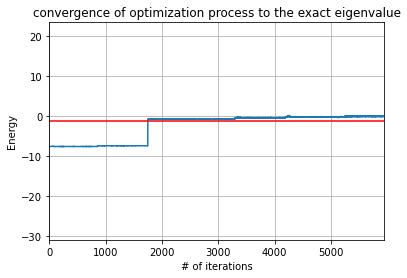

In [44]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [45]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00,  9.48it/s]
7it [00:00, 10.14it/s]
7it [00:00, 10.63it/s]
7it [00:00, 11.38it/s]
7it [00:00, 10.35it/s]
7it [00:00,  9.96it/s]
7it [00:00, 10.59it/s]
7it [00:00, 11.29it/s]
7it [00:00, 10.18it/s]
7it [00:00,  8.60it/s]
7it [00:00, 10.42it/s]
7it [00:00, 10.35it/s]
7it [00:00, 13.01it/s]
7it [00:00,  9.93it/s]
7it [00:00,  9.68it/s]
7it [00:00, 10.40it/s]
7it [00:00,  8.16it/s]
7it [00:00, 11.33it/s]
7it [00:00, 10.14it/s]
7it [00:00, 10.13it/s]
7it [00:00,  9.69it/s]
7it [00:00, 10.28it/s]
7it [00:00, 10.42it/s]
7it [00:01,  6.82it/s]
7it [00:00,  7.52it/s]
7it [00:01,  6.96it/s]
7it [00:00,  7.07it/s]
7it [00:00,  7.88it/s]
7it [00:00,  7.95it/s]
7it [00:00,  7.16it/s]
7it [00:00,  7.44it/s]
7it [00:00,  7.38it/s]
7it [00:00,  8.78it/s]
7it [00:00,  9.23it/s]
7it [00:00, 10.05it/s]
7it [00:00,  9.74it/s]
7it [00:00,  8.85it/s]
7it [00:00,  9.25it/s]
7it [00:00, 10.84it/s]
7it [00:00, 10.67it/s]
7it [00:00,  8.46it/s]
7it [00:00,  9.75it/s]
7it [00:00, 10.41it/s]
7it [00:00,

7it [00:00,  9.01it/s]
7it [00:00, 10.63it/s]
7it [00:00, 10.98it/s]
7it [00:00, 11.85it/s]
7it [00:00, 12.63it/s]
7it [00:00, 11.13it/s]
7it [00:00, 12.62it/s]
7it [00:00, 11.94it/s]
7it [00:00, 11.83it/s]
7it [00:00, 11.08it/s]
7it [00:00, 12.76it/s]
7it [00:00, 11.09it/s]
7it [00:00, 10.99it/s]
7it [00:00, 12.90it/s]
7it [00:00, 10.93it/s]
7it [00:00, 11.88it/s]
7it [00:00, 12.21it/s]
7it [00:00, 12.19it/s]
7it [00:00, 10.42it/s]
7it [00:00, 12.41it/s]
7it [00:00, 11.25it/s]
7it [00:00, 11.16it/s]
7it [00:00, 10.46it/s]
7it [00:00, 10.19it/s]
7it [00:00, 11.33it/s]
7it [00:00, 11.20it/s]
7it [00:00, 12.09it/s]
7it [00:00, 12.86it/s]
7it [00:00,  9.31it/s]
7it [00:00, 10.38it/s]
7it [00:00, 10.16it/s]
7it [00:00, 12.04it/s]
7it [00:00, 10.50it/s]
7it [00:00, 13.57it/s]
7it [00:00, 11.39it/s]
7it [00:00, 11.99it/s]
7it [00:00, 11.83it/s]
7it [00:00, 12.16it/s]
7it [00:00, 10.21it/s]
7it [00:00, 13.27it/s]
7it [00:00, 11.38it/s]
7it [00:00, 11.12it/s]
7it [00:00, 11.17it/s]
7it [00:00,

[0.4824417  4.37020185 4.62121584 2.09995899 3.39229593 1.1812679
 1.78154962 0.66708824 1.8350707  4.12075796 1.97233719 2.5795944
 4.95563951 5.49600893 5.08110695 5.35944033 3.95303737 0.36274309
 5.53556931 2.73104817 1.94113901 2.75387222 0.75658157 4.25256117]


7it [00:00,  9.48it/s]

CPU times: total: 6min 55s
Wall time: 7min 18s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
0.6012492160158511

Approximation Error
0.46919413947014094


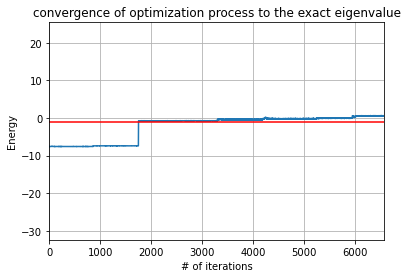

In [46]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [47]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [48]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [49]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 13.30it/s]
3it [00:00, 13.49it/s]
3it [00:00, 17.44it/s]
3it [00:00, 15.59it/s]
3it [00:00, 11.95it/s]
3it [00:00, 16.13it/s]
3it [00:00, 15.37it/s]
3it [00:00, 14.93it/s]
3it [00:00, 13.85it/s]
3it [00:00, 17.41it/s]
3it [00:00, 14.51it/s]
3it [00:00, 13.27it/s]
3it [00:00, 16.93it/s]
3it [00:00, 12.89it/s]
3it [00:00, 14.68it/s]
3it [00:00, 13.69it/s]
3it [00:00, 14.96it/s]
3it [00:00, 13.37it/s]
3it [00:00, 17.56it/s]
3it [00:00, 13.09it/s]
3it [00:00, 16.76it/s]
3it [00:00, 15.24it/s]
3it [00:00, 13.01it/s]
3it [00:00, 11.99it/s]
3it [00:00, 13.09it/s]
3it [00:00, 22.23it/s]
3it [00:00, 15.08it/s]
3it [00:00, 13.73it/s]
3it [00:00, 24.17it/s]
3it [00:00, 17.54it/s]
3it [00:00, 13.06it/s]
3it [00:00, 17.74it/s]
3it [00:00, 17.70it/s]
3it [00:00, 16.09it/s]
3it [00:00, 13.69it/s]
3it [00:00, 16.88it/s]
3it [00:00, 16.94it/s]
3it [00:00, 14.20it/s]
3it [00:00, 12.58it/s]
3it [00:00, 16.43it/s]
3it [00:00, 13.25it/s]
3it [00:00, 12.97it/s]
3it [00:00, 12.62it/s]
3it [00:00,

3it [00:00, 14.39it/s]
3it [00:00, 12.68it/s]
3it [00:00, 13.66it/s]
3it [00:00, 11.23it/s]
3it [00:00, 14.40it/s]
3it [00:00, 11.26it/s]
3it [00:00, 12.01it/s]
3it [00:00, 15.36it/s]
3it [00:00, 10.46it/s]
3it [00:00, 14.95it/s]
3it [00:00, 14.74it/s]
3it [00:00, 14.15it/s]
3it [00:00, 12.85it/s]
3it [00:00, 14.84it/s]
3it [00:00, 12.16it/s]
3it [00:00, 16.32it/s]
3it [00:00, 15.71it/s]
3it [00:00, 13.19it/s]
3it [00:00, 16.86it/s]
3it [00:00, 14.16it/s]
3it [00:00, 13.09it/s]
3it [00:00, 21.42it/s]
3it [00:00, 13.62it/s]
3it [00:00, 14.15it/s]
3it [00:00, 14.23it/s]
3it [00:00, 16.00it/s]
3it [00:00, 16.97it/s]
3it [00:00, 11.63it/s]
3it [00:00, 14.06it/s]
3it [00:00, 15.04it/s]
3it [00:00,  9.58it/s]
3it [00:00, 14.93it/s]
3it [00:00, 16.04it/s]
3it [00:00, 16.17it/s]
3it [00:00, 13.28it/s]
3it [00:00, 14.14it/s]
3it [00:00, 13.10it/s]
3it [00:00, 14.58it/s]
3it [00:00, 26.20it/s]
3it [00:00, 13.87it/s]
3it [00:00, 12.79it/s]
3it [00:00, 18.38it/s]
3it [00:00, 11.58it/s]
3it [00:00,

[4.17583338 3.12484147 0.27650393 3.7658534  1.90702687 1.59534544
 3.46857208 5.41257133 0.58656753 0.13144068 6.13183048 3.37713564
 2.51396683 2.44207251 4.58418054 4.20285055]


3it [00:00, 19.29it/s]

CPU times: total: 1min 20s
Wall time: 1min 24s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.21647869948856086

Approximation Error
0.7892073292723638


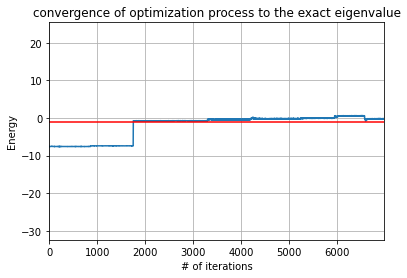

In [50]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [51]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 17.49it/s]
3it [00:00, 14.52it/s]
3it [00:00, 15.69it/s]
3it [00:00, 14.81it/s]
3it [00:00, 14.20it/s]
3it [00:00, 13.72it/s]
3it [00:00, 13.15it/s]
3it [00:00, 15.02it/s]
3it [00:00, 11.97it/s]
3it [00:00, 12.95it/s]
3it [00:00, 13.88it/s]
3it [00:00, 12.92it/s]
3it [00:00, 12.11it/s]
3it [00:00, 16.11it/s]
3it [00:00, 16.89it/s]
3it [00:00, 13.68it/s]
3it [00:00, 13.54it/s]
3it [00:00, 11.81it/s]
3it [00:00, 13.36it/s]
3it [00:00, 15.59it/s]
3it [00:00, 15.15it/s]
3it [00:00, 11.95it/s]
3it [00:00, 11.83it/s]
3it [00:00, 14.09it/s]
3it [00:00, 16.01it/s]
3it [00:00, 20.69it/s]
3it [00:00, 14.47it/s]
3it [00:00, 13.10it/s]
3it [00:00, 12.64it/s]
3it [00:00, 12.84it/s]
3it [00:00, 10.09it/s]
3it [00:00, 14.60it/s]
3it [00:00, 15.88it/s]
3it [00:00, 14.25it/s]
3it [00:00, 13.33it/s]
3it [00:00, 15.37it/s]
3it [00:00, 19.29it/s]
3it [00:00, 12.77it/s]
3it [00:00, 12.11it/s]
3it [00:00, 13.17it/s]
3it [00:00, 12.34it/s]
3it [00:00, 11.81it/s]
3it [00:00, 12.14it/s]
3it [00:00,

3it [00:00, 25.57it/s]
3it [00:00, 28.03it/s]
3it [00:00, 21.86it/s]
3it [00:00, 15.88it/s]
3it [00:00, 23.20it/s]
3it [00:00, 22.19it/s]
3it [00:00, 25.72it/s]
3it [00:00, 12.70it/s]
3it [00:00, 28.50it/s]
3it [00:00, 24.86it/s]
3it [00:00, 20.69it/s]
3it [00:00, 23.66it/s]
3it [00:00, 31.43it/s]
3it [00:00, 22.36it/s]
3it [00:00, 20.38it/s]
3it [00:00, 25.82it/s]
3it [00:00, 19.14it/s]
3it [00:00, 24.42it/s]
3it [00:00, 21.21it/s]
3it [00:00, 26.88it/s]
3it [00:00, 23.65it/s]
3it [00:00, 20.31it/s]
3it [00:00, 25.88it/s]
3it [00:00, 26.71it/s]
3it [00:00, 19.46it/s]
3it [00:00, 21.74it/s]
3it [00:00, 19.26it/s]
3it [00:00, 22.73it/s]
3it [00:00, 27.40it/s]
3it [00:00, 25.58it/s]
3it [00:00, 22.96it/s]
3it [00:00, 15.97it/s]
3it [00:00, 27.27it/s]
3it [00:00, 17.11it/s]
3it [00:00, 23.49it/s]
3it [00:00, 27.17it/s]
3it [00:00, 18.10it/s]
3it [00:00, 23.98it/s]
3it [00:00, 22.08it/s]
3it [00:00, 26.87it/s]
3it [00:00, 18.20it/s]
3it [00:00, 28.74it/s]
3it [00:00, 15.52it/s]
3it [00:00,

[2.74016424 3.52368616 0.16181439 0.13478751 0.21778845 3.10163126
 4.06560298 4.22507846 2.8657344  2.74739679 3.88518299 5.69673153
 0.63193474 1.48720077 2.11093882 1.5771952 ]


3it [00:00, 19.24it/s]

CPU times: total: 1min 20s
Wall time: 1min 23s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.5554991898300685

Approximation Error
0.4590915499402016


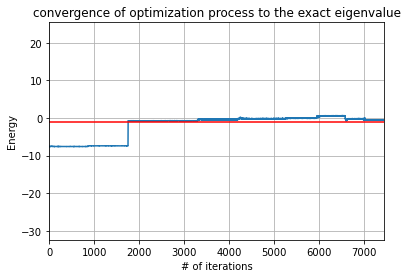

In [52]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [53]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [54]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 19.01it/s]
4it [00:00, 27.80it/s]
4it [00:00, 22.93it/s]
4it [00:00, 17.85it/s]
4it [00:00, 23.29it/s]
4it [00:00, 21.22it/s]
4it [00:00, 16.89it/s]
4it [00:00, 21.24it/s]
4it [00:00, 24.50it/s]
4it [00:00, 22.08it/s]
4it [00:00, 18.47it/s]
4it [00:00, 29.74it/s]
4it [00:00, 27.77it/s]
4it [00:00, 29.04it/s]
4it [00:00, 25.60it/s]
4it [00:00, 42.67it/s]
4it [00:00, 26.94it/s]
4it [00:00, 30.18it/s]
4it [00:00, 23.26it/s]
4it [00:00, 16.48it/s]
4it [00:00, 29.48it/s]
4it [00:00, 19.40it/s]
4it [00:00, 24.59it/s]
4it [00:00, 24.39it/s]
4it [00:00, 23.64it/s]
4it [00:00, 26.40it/s]
4it [00:00, 37.72it/s]
4it [00:00, 17.61it/s]
4it [00:00, 22.14it/s]
4it [00:00, 21.85it/s]
4it [00:00, 17.44it/s]
4it [00:00, 21.23it/s]
4it [00:00, 32.10it/s]
4it [00:00, 29.34it/s]
4it [00:00, 13.20it/s]
4it [00:00, 31.10it/s]
4it [00:00, 20.97it/s]
4it [00:00, 22.58it/s]
4it [00:00, 23.12it/s]
4it [00:00, 23.10it/s]
4it [00:00, 27.05it/s]
4it [00:00, 21.18it/s]
4it [00:00, 19.73it/s]
4it [00:00,

4it [00:00, 15.18it/s]
4it [00:00, 15.32it/s]
4it [00:00, 17.54it/s]
4it [00:00, 15.54it/s]
4it [00:00, 17.66it/s]
4it [00:00, 19.57it/s]
4it [00:00, 17.62it/s]
4it [00:00, 19.93it/s]
4it [00:00, 15.13it/s]
4it [00:00, 16.49it/s]
4it [00:00, 23.23it/s]
4it [00:00, 17.05it/s]
4it [00:00, 13.32it/s]
4it [00:00, 17.94it/s]
4it [00:00, 17.68it/s]
4it [00:00, 17.81it/s]
4it [00:00, 20.36it/s]
4it [00:00, 16.79it/s]
4it [00:00, 16.43it/s]
4it [00:00, 17.65it/s]
4it [00:00, 16.31it/s]
4it [00:00, 19.21it/s]
4it [00:00, 14.91it/s]
4it [00:00, 18.16it/s]
4it [00:00, 23.58it/s]
4it [00:00, 16.34it/s]
4it [00:00, 17.21it/s]
4it [00:00, 19.35it/s]
4it [00:00, 17.81it/s]
4it [00:00, 17.45it/s]
4it [00:00, 22.17it/s]
4it [00:00, 17.03it/s]
4it [00:00, 15.84it/s]
4it [00:00, 20.39it/s]
4it [00:00, 19.63it/s]
4it [00:00, 18.46it/s]
4it [00:00, 14.62it/s]
4it [00:00, 15.88it/s]
4it [00:00, 18.91it/s]
4it [00:00, 16.68it/s]
4it [00:00, 18.90it/s]
4it [00:00, 20.55it/s]
4it [00:00, 17.16it/s]
4it [00:00,

[3.1813446  5.026861   5.20004443 3.66259846 3.01035753 5.1760791
 5.79706349 5.72325493 1.37531053 1.83404471 5.94269296 6.26921828
 4.11650404 4.00355827 3.92069385 4.35035009]


4it [00:00, 15.63it/s]

CPU times: total: 1min 46s
Wall time: 1min 49s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.6678625109005708

Approximation Error
0.3355307375268594


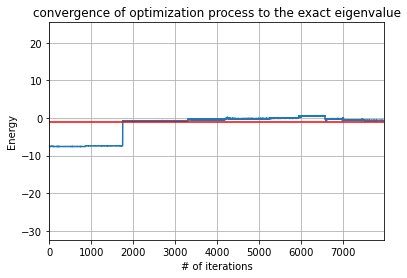

In [55]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [56]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00, 18.75it/s]
4it [00:00, 17.65it/s]
4it [00:00, 17.84it/s]
4it [00:00, 16.39it/s]
4it [00:00, 17.07it/s]
4it [00:00, 21.93it/s]
4it [00:00, 20.93it/s]
4it [00:00, 14.89it/s]
4it [00:00, 22.65it/s]
4it [00:00, 18.19it/s]
4it [00:00, 19.07it/s]
4it [00:00, 19.17it/s]
4it [00:00, 18.12it/s]
4it [00:00, 18.58it/s]
4it [00:00, 19.63it/s]
4it [00:00, 20.22it/s]
4it [00:00, 19.36it/s]
4it [00:00, 15.49it/s]
4it [00:00, 22.81it/s]
4it [00:00, 23.23it/s]
4it [00:00, 17.21it/s]
4it [00:00, 15.95it/s]
4it [00:00, 15.76it/s]
4it [00:00, 15.40it/s]
4it [00:00, 18.43it/s]
4it [00:00, 17.56it/s]
4it [00:00, 16.98it/s]
4it [00:00, 18.28it/s]
4it [00:00, 16.63it/s]
4it [00:00, 14.38it/s]
4it [00:00, 20.98it/s]
4it [00:00, 17.02it/s]
4it [00:00, 16.33it/s]
4it [00:00, 18.85it/s]
4it [00:00, 17.07it/s]
4it [00:00, 19.28it/s]
4it [00:00, 18.75it/s]
4it [00:00, 25.36it/s]
4it [00:00, 15.73it/s]
4it [00:00, 20.29it/s]
4it [00:00, 20.14it/s]
4it [00:00, 17.33it/s]
4it [00:00, 18.68it/s]
4it [00:00,

4it [00:00, 36.57it/s]


[3.03222876 3.08495096 5.39423344 4.95746587 5.9540809  5.96369674
 1.6710862  3.53181324 4.07777295 2.81868568 4.06795384 5.61548736
 3.44807861 4.8696666  0.71742525 5.13605053]


4it [00:00, 21.01it/s]

CPU times: total: 1min 6s
Wall time: 1min 8s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.24217044542214275

Approximation Error
0.7590599642350646


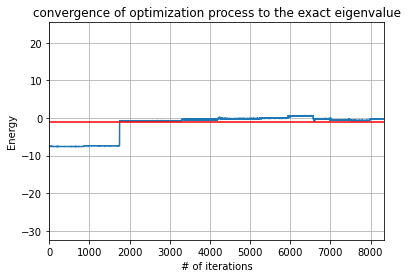

In [57]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)